# Import neccessary libraries

In [ ]:
!pip install polars
!pip install plotly

In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 5.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

In [ ]:
import os
import time
import numpy as np
import polars as pl
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from xgboost import XGBRegressor

# Data Preparation

In [ ]:
class TimeSeriesDataLoader:
    def __init__(self, file_path, input_size, label_size, offset, train_size, val_size,
                 date_column=None, target_name=None, features_type='M', batch_size=64):

        if offset < label_size:
            print(f"Offset will be changed from {offset} to {label_size}")
            offset = label_size

        self.input_size = input_size
        self.label_size = label_size
        self.offset = offset
        self.train_size = train_size
        self.val_size = val_size
        self.target_name = target_name
        self.features_type = features_type
        self.batch_size = batch_size

        # Load the data
        self.df = pl.read_csv(file_path)
        if date_column is not None:
            self.df = self.df.drop('date')

        # Determine in_variable and out_variable based on features_type
        if features_type == 'S':
            self.in_variable = 1
            self.out_variable = 1
        elif features_type == 'M':
            self.in_variable = len(self.df.columns)
            self.out_variable = len(self.df.columns)
        elif features_type == 'MS':
            self.in_variable = len(self.df.columns)
            self.out_variable = 1
        else:
            raise ValueError("Invalid features_type. Choose from 'S' for Univariate-to-Univariate, "
                             "'M' for Multivariate-to-Multivariate, 'MS' for Multivariate-to-Univariate.")

        # Preprocess the data
        self.X_train, self.y_train = self.__create_dataset(0, int(train_size * len(self.df)))
        print(f'{self.X_train.shape=}')
        print(f'{self.y_train.shape=}')

        self.X_val, self.y_val = self.__create_dataset(int(train_size * len(self.df)),
                                                      int((train_size + val_size) * len(self.df)))
        print(f'{self.X_val.shape=}')
        print(f'{self.y_val.shape=}')

        self.X_test, self.y_test = self.__create_dataset(int((train_size + val_size) * len(self.df)), None)
        print(f'{self.X_test.shape=}')
        print(f'{self.y_test.shape=}')

        # Convert to PyTorch DataLoaders
        self.train_loader = self.__create_dataloader(self.X_train, self.y_train)
        self.val_loader = self.__create_dataloader(self.X_val, self.y_val)
        self.test_loader = self.__create_dataloader(self.X_test, self.y_test)

    def __create_dataset(self, start_idx, end_idx):
        if end_idx is None:
            end_idx = len(self.df) - self.label_size - self.offset

        start_idx += self.input_size + self.offset

        features = []
        labels = []

        for idx in range(start_idx, end_idx):
            feature_start_idx = idx - self.input_size - self.offset
            feature_end_idx = feature_start_idx + self.input_size

            label_start_idx = idx - 1
            label_end_idx = label_start_idx + self.label_size

            if self.features_type == 'S':
                feature = self.df.select(self.target_name)[feature_start_idx:feature_end_idx]
                label = self.df.select(self.target_name)[label_start_idx:label_end_idx]
            elif self.features_type == 'M':
                feature = self.df[feature_start_idx:feature_end_idx]
                label = self.df[label_start_idx:label_end_idx]
            elif self.features_type == 'MS':
                feature = self.df[feature_start_idx:feature_end_idx]
                label = self.df.select(self.target_name)[label_start_idx:label_end_idx]
            else:
                raise ValueError("Invalid features_type. Choose from 'S', 'M', 'MS'.")

            features.append(feature.to_numpy())
            labels.append(label.to_numpy())

        self.out_features = label.columns
        self.in_features = feature.columns

        return np.array(features), np.array(labels)

    def __create_dataloader(self, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)
        dataset = TensorDataset(X_tensor, y_tensor)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

In [ ]:
import torch
import torch.nn as nn
import os
import time
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np

class ModelManager:
    def __init__(self, model, train_loader, val_loader=None, lr=0.001, patience=100):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0
        self.criterion = nn.L1Loss()
        self.optimizer = optim.Adam(model.parameters(), lr=lr)

    def train(self, num_epochs, save_dir='.'):
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'best-{self.model.__class__.__name__}.pth')
        for epoch in range(num_epochs):
            start_time = time.time()
            self.model.train()  # Set the model to training mode
            total_train_loss = 0

            for inputs, targets in self.train_loader:
                # Forward pass
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_train_loss += loss.item()

                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            avg_train_loss = total_train_loss / len(self.train_loader)

            # Validate the model
            val_loss = self.evaluate(loader=self.val_loader)

            # Check for early stopping
            if self.early_stopping(val_loss, save_path):
                print(f"Early stopping at epoch {epoch + 1}")
                return

            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'time: {int(time.time() - start_time)}s, '
                  f'loss: {avg_train_loss:.4f}, '
                  f'val_loss: {val_loss:.4f}')

        self.load_model(save_path)

    def evaluate(self, loader):
        self.model.eval()  # Set the model to evaluation mode
        total_loss = 0

        with torch.no_grad():
            for inputs, targets in loader:
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        return avg_loss

    def early_stopping(self, val_loss, save_path):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.save_model(save_path)
        else:
            self.counter += 1
        return self.counter >= self.patience

    def save_model(self, save_path):
        torch.save(self.model.state_dict(), save_path)
        print(f'Model saved to {save_path}')

    def load_model(self, load_path):
        self.model.load_state_dict(torch.load(load_path))
        print(f'Model loaded from {load_path}')

    def predict(self, input_data):
        self.model.eval()  # Set the model to evaluation mode

        if isinstance(input_data, DataLoader):
            # If input_data is a DataLoader, iterate through batches and concatenate predictions
            predictions = []
            with torch.no_grad():
                for inputs, _ in input_data:
                    outputs = self.model(inputs)
                    predictions.append(outputs)
            predictions = torch.cat(predictions, dim=0)
        else:
            # Assume input_data is a single input tensor
            with torch.no_grad():
                predictions = self.model(input_data).unsqueeze(0)

        return predictions

    def plot(self, y, yhat, feature_names=None, save_dir='.', save_plots=True, num_elements=None):
        if feature_names is None:
            feature_names = [f'Feature {i + 1}' for i in range(y.shape[2])]

        if num_elements is not None:
            y = y[:num_elements]
            yhat = yhat[:num_elements]

        for feature_index, feature_name in enumerate(feature_names):
            plt.figure(figsize=(10, 5))

            plt.plot(y[:, :, feature_index].flatten(), label='y', linestyle='-')
            plt.plot(yhat[:, :, feature_index].flatten(), label='y_hat', linestyle='--')

            plt.title(feature_name)
            plt.xlabel('Time Step')
            plt.ylabel('Values')
            plt.legend()

            if save_plots:
                # Create the save directory if it doesn’t exist
                os.makedirs(os.path.join(save_dir, self.model.__class__.__name__), exist_ok=True)

                # Save the plot
                save_path = os.path.join(save_dir, self.model.__class__.__name__, f'{feature_name}.png')
                plt.savefig(save_path)

            plt.show()
            plt.close()  # Close the plot to avoid overlapping in saved images


class MachineLearningModelManager(ModelManager):
    def __init__(self, model, xtrain, ytrain, xval, yval):
        self.model = model
        self.xtrain = xtrain
        self.ytrain = ytrain
        self.xval = xval
        self.yval = yval

    def preprocessing(self, x):
        return x.reshape(x.shape[0], -1)

    def save_model(self, save_path):
        import pickle
        with open(save_path, 'wb') as model_file:
            pickle.dump(self.model, model_file)
        print(f'Model saved to {save_path}')

    def train(self, save_dir='.'):
        self.model.fit(self.preprocessing(self.xtrain),
                       self.preprocessing(self.ytrain),
                       eval_set=[(self.preprocessing(self.xval), self.preprocessing(self.yval))])
        save_path = os.path.join(save_dir, f'best-{self.model.__class__.__name__}.pkl')
        self.save_model(save_path=save_path)

    def predict(self, x):
        return self.model.predict(self.preprocessing(x))

    def evaluate(self, x, y):
        from sklearn.metrics import mean_absolute_error
        return mean_absolute_error(self.preprocessing(y), self.predict(self.preprocessing(x)))

    def plot(self, y, yhat, feature_names=None, save_dir='.', save_plots=True, num_elements=None):
        yhat = yhat.reshape(y.shape[0], y.shape[1], -1)
        super().plot(y, yhat, feature_names=feature_names, save_dir=save_dir, save_plots=save_plots, num_elements=num_elements)

# Model

In [ ]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, ahead):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size * ahead)
        self.ahead = ahead
        self.output_size = output_size

    def forward(self, x):
    # Flatten the input
        x = x.view(x.size(0), -1)  # Reshape from [batch, lag, features] to [batch, lag * features]
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x.view(-1, self.ahead, self.output_size)  # Reshape to [batch, ahead, features]

In [ ]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size

        # RNN Layer - can be replaced with nn.LSTM or nn.GRU
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size * ahead)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)

        # Get the last time step's output for each sequence
        out = out[:, -1, :]

        # Pass through the linear layer and reshape
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out

In [ ]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size

        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size * ahead)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Get the last time step's output for each sequence
        out = out[:, -1, :]

        # Pass through the linear layer and reshape
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out

In [ ]:
import torch
import torch.nn as nn

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size

        # BiLSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

        # Output layer
        # Output size is doubled because BiLSTM has two hidden states for each layer
        self.fc = nn.Linear(hidden_size * 2, output_size * ahead)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # 2 for bidirection
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate BiLSTM
        out, _ = self.lstm(x, (h0, c0))

        # Get the last time step's output for each sequence
        out = out[:, -1, :]

        # Pass through the linear layer and reshape
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out

# Configurations

In [ ]:
# Configurations
input_size = 336
label_size = 96
offset = 1
train_size = 0.7
val_size = 0.1
num_epochs = 1_000_000
patience = 20
learning_rate = 0.001
hidden_size = 64
num_layers = 2
ele = 5
target_name = 'OT'
date_column = 'date'
file_path = 'ETTh1.csv'
plot_dir = 'plots'
weight_dir = 'weights'
results = []


# EDA

In [ ]:
%matplotlib inline
sns.set_theme()

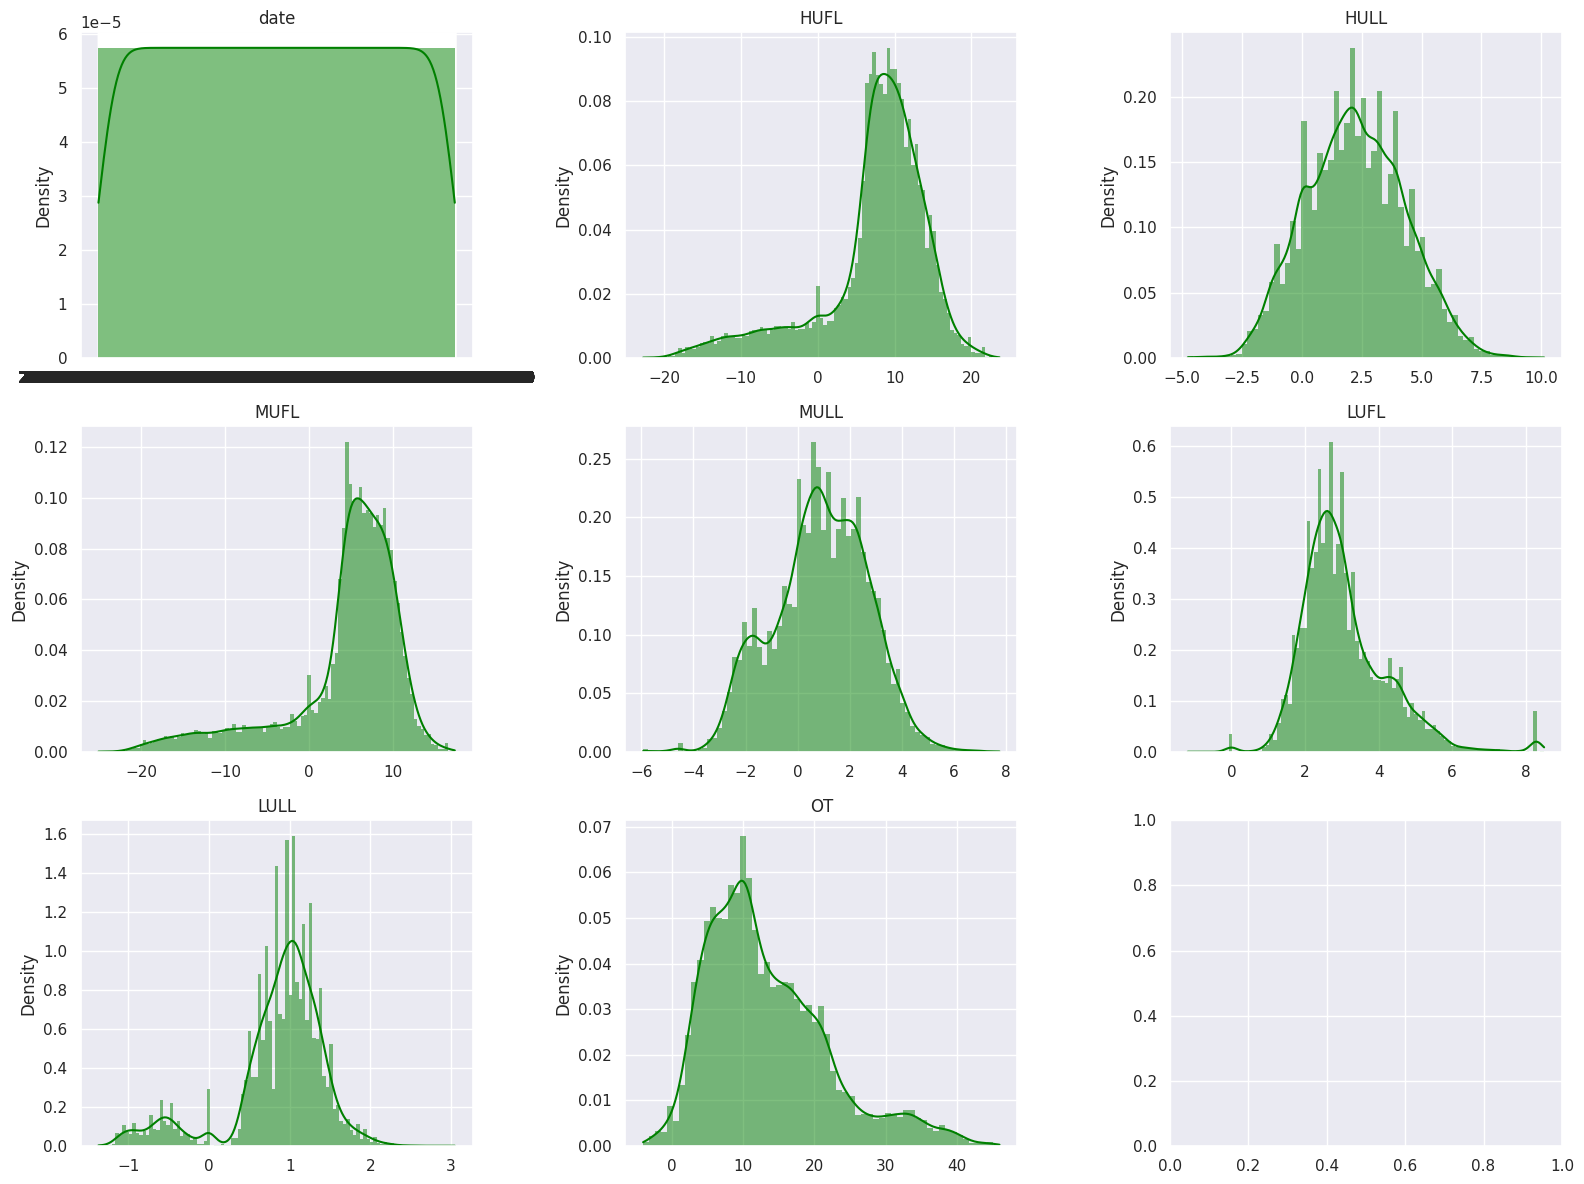

In [ ]:
train_df = pl.read_csv(file_path)
columns_to_plot = train_df.columns

num_columns = 3
num_rows = int(np.ceil(len(columns_to_plot) / num_columns))
grid_layout = (num_rows, num_columns)

fig, axes = plt.subplots(*grid_layout, figsize=(16, 12))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    sns.histplot(train_df[column], kde=True, ax=axes[i], color='green', stat="density", linewidth=0)
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

# Heat Map

In [ ]:
import pandas as pd

In [ ]:
train_df = pd.read_csv(file_path)
train_df_corr = train_df.drop("date", axis = 1)

In [ ]:
train_df_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17420 entries, 0 to 17419
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HUFL    17420 non-null  float64
 1   HULL    17420 non-null  float64
 2   MUFL    17420 non-null  float64
 3   MULL    17420 non-null  float64
 4   LUFL    17420 non-null  float64
 5   LULL    17420 non-null  float64
 6   OT      17420 non-null  float64
dtypes: float64(7)
memory usage: 952.8 KB


In [ ]:
# corr
df_corr = train_df_corr.corr() #Get correlation data
df_corr

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
HUFL,1.000000,0.114672,0.987355,0.066002,0.291418,0.023606,0.059916
HULL,0.114672,1.000000,0.068817,0.930491,0.259487,0.377641,0.224354
MUFL,0.987355,0.068817,1.000000,0.046266,0.177491,-0.046519,0.050854
MULL,0.066002,0.930491,0.046266,1.000000,0.128607,0.069419,0.220004
LUFL,0.291418,0.259487,0.177491,0.128607,1.000000,0.334563,0.118836
LULL,0.023606,0.377641,-0.046519,0.069419,0.334563,1.000000,0.067455
OT,0.059916,0.224354,0.050854,0.220004,0.118836,0.067455,1.000000


In [ ]:
# ones_like can build a matrix of boolean (True, False) with the same shape as our data
ones_corr  = np.ones_like(df_corr,dtype=bool)

In [ ]:
ones_corr.shape, df_corr.shape

((7, 7), (7, 7))

In [ ]:
# np. triu: return only upper triangle matrix
mask = np.triu(ones_corr)

In [ ]:
mask

array([[ True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True],
       [False, False,  True,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True],
       [False, False, False, False,  True,  True,  True],
       [False, False, False, False, False,  True,  True],
       [False, False, False, False, False, False,  True]])

In [ ]:
adjusted_mask = mask[1:,:-1]

In [ ]:
adjusted_mask

array([[False,  True,  True,  True,  True,  True],
       [False, False,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True],
       [False, False, False, False,  True,  True],
       [False, False, False, False, False,  True],
       [False, False, False, False, False, False]])

In [ ]:
adjusted_df_corr = df_corr.iloc[1:,:-1]

In [ ]:
adjusted_df_corr

,HUFL,HULL,MUFL,MULL,LUFL,LULL
HULL,0.114672,1.000000,0.068817,0.930491,0.259487,0.377641
MUFL,0.987355,0.068817,1.000000,0.046266,0.177491,-0.046519
MULL,0.066002,0.930491,0.046266,1.000000,0.128607,0.069419
LUFL,0.291418,0.259487,0.177491,0.128607,1.000000,0.334563
LULL,0.023606,0.377641,-0.046519,0.069419,0.334563,1.000000
OT,0.059916,0.224354,0.050854,0.220004,0.118836,0.067455


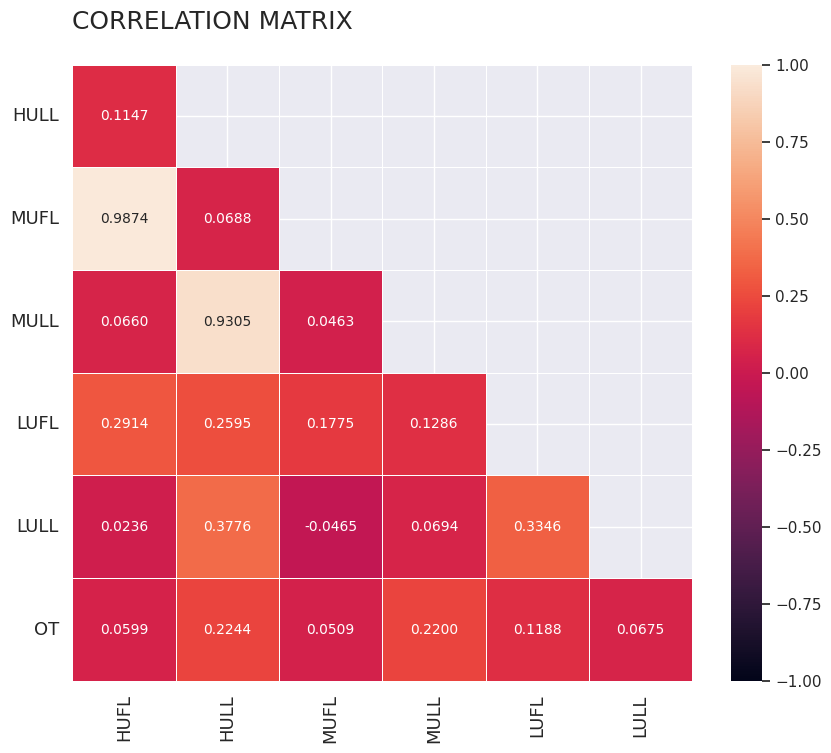

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

#That method uses HUSL colors, so you need hue, saturation, and lightness.
#I used hsluv.org to select the colors of this chart.
#cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

sns.heatmap(data= adjusted_df_corr, mask=adjusted_mask,
            annot=True, annot_kws={"fontsize":10}, fmt=".4f",
            vmin=-1, vmax=1,
            linecolor='white', linewidths=0.5);

yticks = [i.upper() for i in adjusted_df_corr.index]
xticks = [i.upper() for i in adjusted_df_corr.columns]

ax.set_yticklabels(yticks, rotation=0, fontsize=13);
ax.set_xticklabels(xticks, rotation=90, fontsize=13);
title = 'CORRELATION MATRIX\n'
ax.set_title(title, loc='left', fontsize=18);

# Case study 1 (multivariate to multivariate)

In [ ]:
# Định nghĩa multi2multi_loader
multi2multi_loader = TimeSeriesDataLoader(
    file_path='/content/ETTh1.csv',
    input_size=input_size,
    label_size=label_size,
    offset=offset,
    train_size=train_size,
    val_size=val_size,
    target_name=target_name,
    features_type='M',  # Multivariate to Multivariate
    date_column='date'
)

# Định nghĩa sub_dir
sub_dir = 'multi2multi'

Offset will be changed from 1 to 96
self.X_train.shape=(11762, 336, 7)
self.y_train.shape=(11762, 96, 7)
self.X_val.shape=(1309, 336, 7)
self.y_val.shape=(1309, 96, 7)
self.X_test.shape=(2861, 336, 7)
self.y_test.shape=(2861, 96, 7)


Giải thuật MLP

In [ ]:
MLP_multi2multi = MLP(
    input_size=multi2multi_loader.in_variable * input_size,
    hidden_size=hidden_size,
    output_size=multi2multi_loader.out_variable,
    ahead=label_size
)

MLP_multi2multi_manager = ModelManager(
    model=MLP_multi2multi,
    train_loader=multi2multi_loader.train_loader,
    val_loader=multi2multi_loader.val_loader,
    lr=learning_rate,
    patience=patience
)

MLP_multi2multi_manager.train(
    num_epochs=num_epochs,
    save_dir=os.path.join(weight_dir, sub_dir)
)

results.append({
    "Name": MLP_multi2multi_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": MLP_multi2multi_manager.evaluate(loader=multi2multi_loader.test_loader)
})

results[-1]

Model saved to weights/multi2multi/best-MLP.pth
Epoch [1/1000000], time: 0s, loss: 3.1021, val_loss: 3.7157
Epoch [2/1000000], time: 0s, loss: 2.3158, val_loss: 3.7530
Model saved to weights/multi2multi/best-MLP.pth
Epoch [3/1000000], time: 0s, loss: 2.2046, val_loss: 3.5142
Model saved to weights/multi2multi/best-MLP.pth
Epoch [4/1000000], time: 0s, loss: 2.1316, val_loss: 3.1198
Model saved to weights/multi2multi/best-MLP.pth
Epoch [5/1000000], time: 1s, loss: 2.0724, val_loss: 2.8926
Model saved to weights/multi2multi/best-MLP.pth
Epoch [6/1000000], time: 1s, loss: 2.0037, val_loss: 2.8326
Model saved to weights/multi2multi/best-MLP.pth
Epoch [7/1000000], time: 1s, loss: 1.9825, val_loss: 2.7833
Model saved to weights/multi2multi/best-MLP.pth
Epoch [8/1000000], time: 1s, loss: 1.9666, val_loss: 2.7222
Model saved to weights/multi2multi/best-MLP.pth
Epoch [9/1000000], time: 1s, loss: 1.9444, val_loss: 2.6464
Epoch [10/1000000], time: 1s, loss: 1.9064, val_loss: 2.6686
Epoch [11/10000

{'Name': 'MLP', 'Type': 'multi2multi', 'MAE': 2.4610947132110597}

Compare actual and predicted value

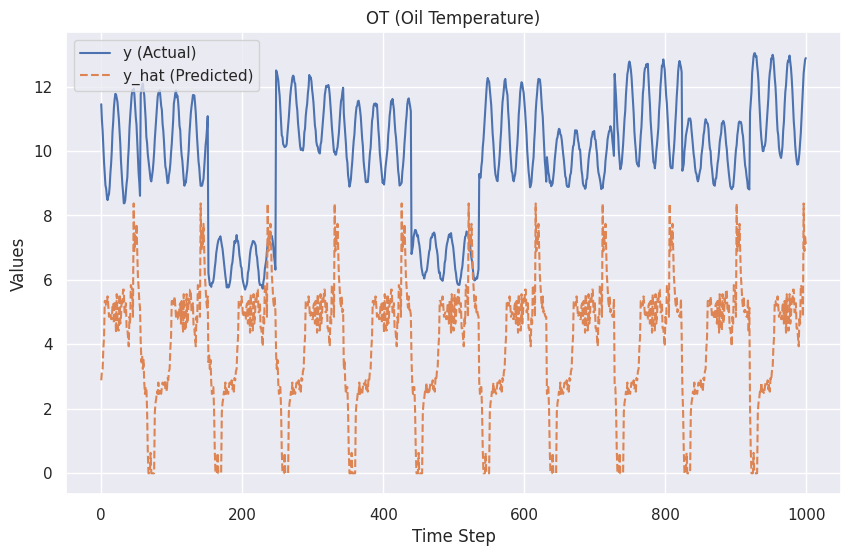

In [39]:
import matplotlib.pyplot as plt

# Lấy mô hình đã huấn luyện và dự đoán trên tập test
predictions = MLP_multi2multi_manager.predict(multi2multi_loader.test_loader)
actuals = multi2multi_loader.y_test


# Dự đoán cột OT bằng mô hình đã huấn luyện
# Giả sử predictions chứa giá trị dự đoán và actuals chứa giá trị thực tế

# Chọn cột OT (giả sử cột OT là cột thứ 6 trong bảng dữ liệu)
column_index = 6  # Thay đổi nếu cột OT nằm ở vị trí khác

# Lấy dữ liệu thực tế và dự đoán cho cột OT
predicted_ot = predictions[:, :, column_index].flatten()
actual_ot = actuals[:, :, column_index].flatten()

# Lựa chọn khoảng thời gian từ 1000 đến 2000
start = 1000
end = 2000
predicted_ot_zoomed = predicted_ot[start:end]
actual_ot_zoomed = actual_ot[start:end]

# Vẽ lại biểu đồ với số điểm dữ liệu ít hơn
plt.figure(figsize=(10, 6))
plt.plot(predicted_ot_zoomed, label='y (Actual)', linestyle='-')
plt.plot(actual_ot_zoomed, label='y_hat (Predicted)', linestyle='--')
plt.title('OT (Oil Temperature)')
plt.xlabel('Time Step')
plt.ylabel('Values')
plt.legend()
plt.show()

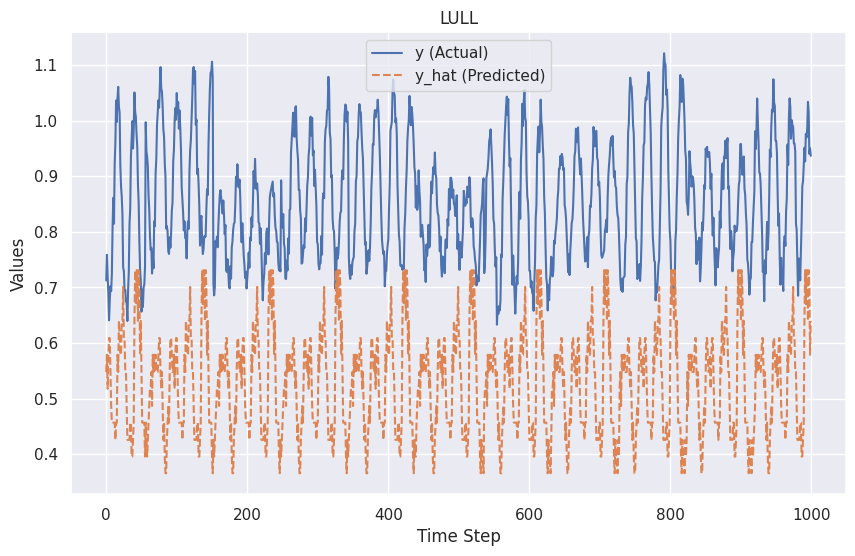

In [42]:
# Chọn cột OT (giả sử cột OT là cột thứ 6 trong bảng dữ liệu)
column_index = 5  # Thay đổi nếu cột OT nằm ở vị trí khác

# Lấy dữ liệu thực tế và dự đoán cho cột OT
predicted_ot = predictions[:, :, column_index].flatten()
actual_ot = actuals[:, :, column_index].flatten()

# Lựa chọn khoảng thời gian từ 1000 đến 2000
start = 1000
end = 2000
predicted_ot_zoomed = predicted_ot[start:end]
actual_ot_zoomed = actual_ot[start:end]

# Vẽ lại biểu đồ với số điểm dữ liệu ít hơn
plt.figure(figsize=(10, 6))
plt.plot(predicted_ot_zoomed, label='y (Actual)', linestyle='-')
plt.plot(actual_ot_zoomed, label='y_hat (Predicted)', linestyle='--')
plt.title('LULL')
plt.xlabel('Time Step')
plt.ylabel('Values')
plt.legend()
plt.show()

In [41]:
train_df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


RNN Training and Performance Evaluation

In [40]:
RNN_multi2multi = RNN(
    input_size=multi2multi_loader.in_variable,
    hidden_size=hidden_size,
    output_size=multi2multi_loader.out_variable,
    ahead=label_size,
    num_layers=num_layers
)

RNN_multi2multi_manager = ModelManager(
    model=RNN_multi2multi,
    train_loader=multi2multi_loader.train_loader,
    val_loader=multi2multi_loader.val_loader,
    lr=learning_rate,
    patience=patience
)

RNN_multi2multi_manager.train(
    num_epochs=num_epochs,
    save_dir=os.path.join(weight_dir, sub_dir)
)

results.append({
    "Name": RNN_multi2multi_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": RNN_multi2multi_manager.evaluate(loader=multi2multi_loader.test_loader)
})

results[-1]

KeyboardInterrupt: 

LSTM Training and Performance Evaluation

In [ ]:
LSTM_multi2multi = LSTM(
    input_size=multi2multi_loader.in_variable,
    hidden_size=hidden_size,
    output_size=multi2multi_loader.out_variable,
    ahead=label_size,
    num_layers=num_layers
)

LSTM_multi2multi_manager = ModelManager(
    model=LSTM_multi2multi,
    train_loader=multi2multi_loader.train_loader,
    val_loader=multi2multi_loader.val_loader,
    lr=learning_rate,
    patience=patience
)

LSTM_multi2multi_manager.train(
    num_epochs=num_epochs,
    save_dir=os.path.join(weight_dir, sub_dir)
)

results.append({
    "Name": LSTM_multi2multi_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": LSTM_multi2multi_manager.evaluate(loader=multi2multi_loader.test_loader)
})

results[-1]

Bi - LSTM Training and Performance Evaluation

In [ ]:
BiLSTM_multi2multi = BiLSTM(
    input_size=multi2multi_loader.in_variable,
    hidden_size=hidden_size,
    output_size=multi2multi_loader.out_variable,
    ahead=label_size,
    num_layers=num_layers
)

BiLSTM_multi2multi_manager = ModelManager(
    model=BiLSTM_multi2multi,
    train_loader=multi2multi_loader.train_loader,
    val_loader=multi2multi_loader.val_loader,
    lr=learning_rate,
    patience=patience
)

BiLSTM_multi2multi_manager.train(
    num_epochs=num_epochs,
    save_dir=os.path.join(weight_dir, sub_dir)
)

results.append({
    "Name": BiLSTM_multi2multi_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": BiLSTM_multi2multi_manager.evaluate(loader=multi2multi_loader.test_loader)
})

results[-1]

XGBoost Training and Performance Evaluation

In [ ]:
XGBoost_multi2multi = XGBRegressor(**xgboost_config)

XGBoost_multi2multi_manager = MachineLearningModelManager(
    model=XGBoost_multi2multi,
    xtrain=multi2multi_loader.X_train,
    ytrain=multi2multi_loader.y_train,
    xval=multi2multi_loader.X_val,
    yval=multi2multi_loader.y_val
)

XGBoost_multi2multi_manager.train(save_dir=os.path.join(weight_dir, sub_dir))

results.append({
    "Name": XGBoost_multi2multi_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": XGBoost_multi2multi_manager.evaluate(
        x=multi2multi_loader.X_test,
        y=multi2multi_loader.y_test
    )
})

results[-1]

# Case study 2 (multivariate to univariate)

In [ ]:
# Định nghĩa multi2multi_loader
multi2multi_loader = TimeSeriesDataLoader(
    file_path='/content/ETTh1.csv',
    input_size=input_size,
    label_size=label_size,
    offset=offset,
    train_size=train_size,
    val_size=val_size,
    target_name=target_name,
    features_type='M',  # Multivariate to Multivariate
    date_column='date_column_name'
)

# Định nghĩa sub_dir
sub_dir = 'multi2multi'

Giải thuật MLP

In [ ]:
MLP_multi2uni = MLP(
    input_size=multi2uni_loader.in_variable * input_size,
    hidden_size=hidden_size,
    output_size=multi2uni_loader.out_variable,
    ahead=label_size
)

MLP_multi2uni_manager = ModelManager(
    model=MLP_multi2uni,
    train_loader=multi2uni_loader.train_loader,
    val_loader=multi2uni_loader.val_loader,
    lr=learning_rate,
    patience=patience
)

MLP_multi2uni_manager.train(
    num_epochs=num_epochs,
    save_dir=os.path.join(weight_dir, sub_dir)
)

results.append({
    "Name": MLP_multi2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": MLP_multi2uni_manager.evaluate(loader=multi2uni_loader.test_loader)
})

results[-1]

RNN Training and Performance Evaluation

In [ ]:
RNN_multi2uni = RNN(
    input_size=multi2uni_loader.in_variable,
    hidden_size=hidden_size,
    output_size=multi2uni_loader.out_variable,
    ahead=label_size,
    num_layers=num_layers
)

RNN_multi2uni_manager = ModelManager(
    model=RNN_multi2uni,
    train_loader=multi2uni_loader.train_loader,
    val_loader=multi2uni_loader.val_loader,
    lr=learning_rate,
    patience=patience
)

RNN_multi2uni_manager.train(
    num_epochs=num_epochs,
    save_dir=os.path.join(weight_dir, sub_dir)
)

results.append({
    "Name": RNN_multi2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": RNN_multi2uni_manager.evaluate(loader=multi2uni_loader.test_loader)
})

results[-1]

LSTM Training and Performance Evaluation

In [ ]:
LSTM_multi2uni = LSTM(
    input_size=multi2uni_loader.in_variable,
    hidden_size=hidden_size,
    output_size=multi2uni_loader.out_variable,
    ahead=label_size,
    num_layers=num_layers
)

LSTM_multi2uni_manager = ModelManager(
    model=LSTM_multi2uni,
    train_loader=multi2uni_loader.train_loader,
    val_loader=multi2uni_loader.val_loader,
    lr=learning_rate,
    patience=patience
)

LSTM_multi2uni_manager.train(
    num_epochs=num_epochs,
    save_dir=os.path.join(weight_dir, sub_dir)
)

results.append({
    "Name": LSTM_multi2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": LSTM_multi2uni_manager.evaluate(loader=multi2uni_loader.test_loader)
})

results[-1]

Bi-LSTM Training and Performance Evaluation

In [ ]:
BiLSTM_multi2uni = BiLSTM(
    input_size=multi2uni_loader.in_variable,
    hidden_size=hidden_size,
    output_size=multi2uni_loader.out_variable,
    ahead=label_size,
    num_layers=num_layers
)

BiLSTM_multi2uni_manager = ModelManager(
    model=BiLSTM_multi2uni,
    train_loader=multi2uni_loader.train_loader,
    val_loader=multi2uni_loader.val_loader,
    lr=learning_rate,
    patience=patience
)

BiLSTM_multi2uni_manager.train(
    num_epochs=num_epochs,
    save_dir=os.path.join(weight_dir, sub_dir)
)

results.append({
    "Name": BiLSTM_multi2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": BiLSTM_multi2uni_manager.evaluate(loader=multi2uni_loader.test_loader)
})

results[-1]

XGboost Training and Performance Evaluation

In [ ]:
XGBoost_multi2uni = XGBRegressor(**xgboost_config)

XGBoost_multi2uni_manager = MachineLearningModelManager(
    model=XGBoost_multi2uni,
    xtrain=multi2uni_loader.X_train,
    ytrain=multi2uni_loader.y_train,
    xval=multi2uni_loader.X_val,
    yval=multi2uni_loader.y_val
)

XGBoost_multi2uni_manager.train(save_dir=os.path.join(weight_dir, sub_dir))

results.append({
    "Name": XGBoost_multi2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": XGBoost_multi2uni_manager.evaluate(
        x=multi2uni_loader.X_test,
        y=multi2uni_loader.y_test
    )
})

results[-1]

# Case study 3 (univariate to univariate)

Giải thuật MLP

In [ ]:
MLP_uni2uni = MLP(
    input_size=uni2uni_loader.in_variable * input_size,
    hidden_size=hidden_size,
    output_size=uni2uni_loader.out_variable,
    ahead=label_size
)

MLP_uni2uni_manager = ModelManager(
    model=MLP_uni2uni,
    train_loader=uni2uni_loader.train_loader,
    val_loader=uni2uni_loader.val_loader,
    lr=learning_rate,
    patience=patience
)

MLP_uni2uni_manager.train(
    num_epochs=num_epochs,
    save_dir=os.path.join(weight_dir, sub_dir)
)

results.append({
    "Name": MLP_uni2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": MLP_uni2uni_manager.evaluate(loader=uni2uni_loader.test_loader)
})

results[-1]

RNN Training and Performance Evaluation

In [ ]:
RNN_uni2uni = RNN(
    input_size=uni2uni_loader.in_variable,
    hidden_size=hidden_size,
    output_size=uni2uni_loader.out_variable,
    ahead=label_size,
    num_layers=num_layers
)

RNN_uni2uni_manager = ModelManager(
    model=RNN_uni2uni,
    train_loader=uni2uni_loader.train_loader,
    val_loader=uni2uni_loader.val_loader,
    lr=learning_rate,
    patience=patience
)

RNN_uni2uni_manager.train(
    num_epochs=num_epochs,
    save_dir=os.path.join(weight_dir, sub_dir)
)

results.append({
    "Name": RNN_uni2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": RNN_uni2uni_manager.evaluate(loader=uni2uni_loader.test_loader)
})

results[-1]

LSTM Training and Performance Evaluation

In [ ]:
LSTM_uni2uni = LSTM(
    input_size=uni2uni_loader.in_variable,
    hidden_size=hidden_size,
    output_size=uni2uni_loader.out_variable,
    ahead=label_size,
    num_layers=num_layers
)

LSTM_uni2uni_manager = ModelManager(
    model=LSTM_uni2uni,
    train_loader=uni2uni_loader.train_loader,
    val_loader=uni2uni_loader.val_loader,
    lr=learning_rate,
    patience=patience
)

LSTM_uni2uni_manager.train(
    num_epochs=num_epochs,
    save_dir=os.path.join(weight_dir, sub_dir)
)

results.append({
    "Name": LSTM_uni2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": LSTM_uni2uni_manager.evaluate(loader=uni2uni_loader.test_loader)
})

results[-1]

Bi-LSTM Training and Performance Evaluation

In [ ]:
BiLSTM_uni2uni = BiLSTM(
    input_size=uni2uni_loader.in_variable,
    hidden_size=hidden_size,
    output_size=uni2uni_loader.out_variable,
    ahead=label_size,
    num_layers=num_layers
)

BiLSTM_uni2uni_manager = ModelManager(
    model=BiLSTM_uni2uni,
    train_loader=uni2uni_loader.train_loader,
    val_loader=uni2uni_loader.val_loader,
    lr=learning_rate,
    patience=patience
)

BiLSTM_uni2uni_manager.train(
    num_epochs=num_epochs,
    save_dir=os.path.join(weight_dir, sub_dir)
)

results.append({
    "Name": BiLSTM_uni2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": BiLSTM_uni2uni_manager.evaluate(loader=uni2uni_loader.test_loader)
})

results[-1]

XGboost Training and Performance Evaluation

In [ ]:
XGBoost_uni2uni = XGBRegressor(**xgboost_config)

XGBoost_uni2uni_manager = MachineLearningModelManager(
    model=XGBoost_uni2uni,
    xtrain=uni2uni_loader.X_train,
    ytrain=uni2uni_loader.y_train,
    xval=uni2uni_loader.X_val,
    yval=uni2uni_loader.y_val
)

XGBoost_uni2uni_manager.train(save_dir=os.path.join(weight_dir, sub_dir))

results.append({
    "Name": XGBoost_uni2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": XGBoost_uni2uni_manager.evaluate(
        x=uni2uni_loader.X_test,
        y=uni2uni_loader.y_test
    )
})

results[-1]

In [ ]:
XGBoost_uni2uni = XGBRegressor(**xgboost_config)

XGBoost_uni2uni_manager = MachineLearningModelManager(
    model=XGBoost_uni2uni,
    xtrain=uni2uni_loader.X_train,
    ytrain=uni2uni_loader.y_train,
    xval=uni2uni_loader.X_val,
    yval=uni2uni_loader.y_val
)

XGBoost_uni2uni_manager.train(save_dir=os.path.join(weight_dir, sub_dir))

results.append({
    "Name": XGBoost_uni2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": XGBoost_uni2uni_manager.evaluate(
        x=uni2uni_loader.X_test,
        y=uni2uni_loader.y_test
    )
})

results[-1]